# Blackbird Drag Estimations

This is a notebook to do some initial drag estimations. Common drag estimations is a simple proportional speed although there are other methods such as angle of attack that might be useful.

## Load the Dataset

In [1]:
import importlib
import os
os.environ['NUMBA_DISABLE_INTEL_SVML'] = '1'
import pdb
import sys
import time
# sys.path.append(os.path.abspath('../functions'))

from thesis.data import blackbird_dataset as rbd
from thesis.modules import dsp
from thesis.modules import quaternions

%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import ticker
from mpl_toolkits.mplot3d import Axes3D

import numba
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression

In [2]:
# Set up some plotting specifications
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [3]:
# Initial read in
t1 = time.time()
test_df = rbd.read_blackbird_test('figure8', 'Constant', 0.5)
print("Time elapsed: %f" % (time.time() - t1))
# test_df.info()

Time elapsed: 21.087302


In [4]:
# Stable manipulations
print('Time elapsed breakdown')

t1 = time.time()
rbd.imu_installation_correction(test_df)
t2 = time.time()
print('\tIMU correction = %f [s]' % (t2 - t1))

test_df = rbd.inertial_position_derivatives_estimation(test_df)
t3 = time.time()
print('\tInertial position derivative estimates = %f [s]' % (t3 - t2))

test_df = rbd.gyroscope_derivatives_estimation(test_df)
t4 = time.time()
print('\tGyroscope derivative estimates = %f [s]' % (t4 - t3))

test_df = rbd.consistent_quaternions(test_df)
t5 = time.time()
print('\tConsistent quaternions = %f [s]' % (t5 - t4))

test_df = rbd.inertial_quaternion_derivatives_estimation(test_df)
t6 = time.time()
print('\tQuaternion derivate estimates = %f [s]' % (t6 - t5))

test_df = rbd.body_quaternion_angular_derivative_estimate(test_df)
t7 = time.time()
print('\tBody rates from quaternion derivatives = %f [s]' % (t7-t6))

test_df = rbd.motor_scaling(test_df)
t8 = time.time()
print('\tRescale motor angular rates = %f [s]' % (t8 - t7))

test_df = rbd.motor_rates(test_df)
t9 = time.time()
print('\tMotor derivates = %f [s]' % (t9 - t8))

test_df = rbd.quaternion_body_acceleration(test_df)
t10 = time.time()
print('\tPut in body frame accelerations = %f' % (t10 - t9))

test_df = rbd.on_ground(test_df)
t11 = time.time()
print('\tBoolean for flying = %f [s]' % (t11 - t10))

print('Total time elapsed = %f' % (t11 - t1))
test_df.info()

Time elapsed breakdown
	IMU correction = 0.253243 [s]
	Inertial position derivative estimates = 110.530928 [s]
	Gyroscope derivative estimates = 30.548174 [s]
	Consistent quaternions = 2.084197 [s]
	Quaternion derivate estimates = 145.681912 [s]
	Body rates from quaternion derivatives = 3.359291 [s]
	Rescale motor angular rates = 0.636664 [s]
	Motor derivates = 73.764035 [s]
	Put in body frame accelerations = 13.974068
	Boolean for flying = 58.988383 [s]
Total time elapsed = 439.820895
<class 'pandas.core.frame.DataFrame'>
Int64Index: 702053 entries, 1526617312016142000 to 1526617526742182000
Data columns (total 91 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   PWM1                            39823 non-null   float64
 1   PWM2                            39823 non-null   float64
 2   PWM3                            39823 non-null   float64
 3   PWM4                            39823 non-null   flo

## Aerodynamics

There are a couple drag models for quadcopters. MIT, Parrot and DJI use kinematic drag i.e. drag that is proportional to the translational speed. This model tends to be good for $C_D$ that is initially inversely proportional to the Reynolds Number. Another model is an empirical one put out by some Australians that have an angle of attack based longitudinal drag model.

### Filtering for nominal flight

First thing is to determine the regions of a flight region that is "nominal" for drag estimations. This is to avoid lots of transient responses as well as most off axis accelertions from assymetries in the motors.


In [5]:
# Getting body frame centric translational X-Y drag
vehicle = rbd.BlackbirdVehicle()

flying_df = test_df[test_df['is_flying']]

drag_force = flying_df[[
    'ax_B_[m/s2]', 'ay_B_[m/s2]', 'az_B_[m/s2]'
]].dropna()

rbts2s = 10 ** -9
tvec = (drag_force.index - test_df.index[0]) * rbts2s
tvec = tvec.astype('float').values

drag_force = (
    drag_force.values - flying_df[[
        'ax_g|B_[m/s2]',
        'ay_g|B_[m/s2]',
        'az_g|B_[m/s2]'
    ]].dropna().values
) * vehicle.mass

In [6]:
# Vehicle body velocities
velocity = flying_df[['vx_B_[m/s]', 'vy_B_[m/s]', 'vz_B_[m/s]']].dropna().values
vel_smoothed = dsp.adaptive_low_pass(tvec, velocity, fc=2.5)

median_vel = np.median(velocity, axis=0)
Q1_vel = np.zeros(3)
Q3_vel = np.zeros(3)

for i in range(3):
    v = velocity[:, i]
    Q1_vel[i] = np.median(v[v < median_vel[i]])
    Q3_vel[i] = np.median(v[v > median_vel[i]])

print(Q1_vel)

[-0.13888064 -0.10654166 -0.0062233 ]


<IPython.core.display.Javascript object>


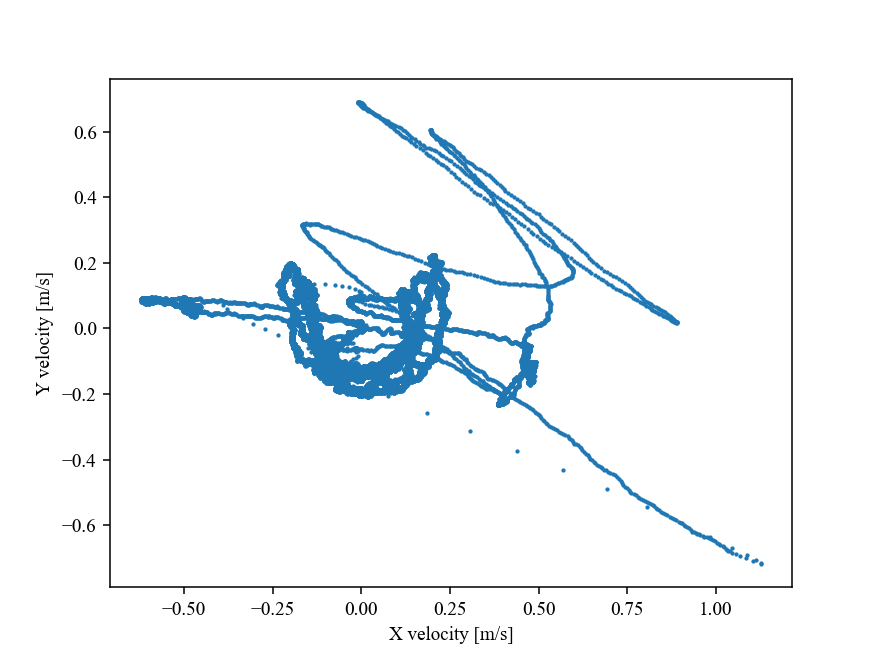

In [7]:
fig, ax = plt.subplots(1, 1)

ax.scatter(velocity[:, 0], velocity[:, 1], s=1.5)

ax.set_xlabel('X velocity [m/s]')
ax.set_ylabel('Y velocity [m/s]')

plt.show()

<IPython.core.display.Javascript object>


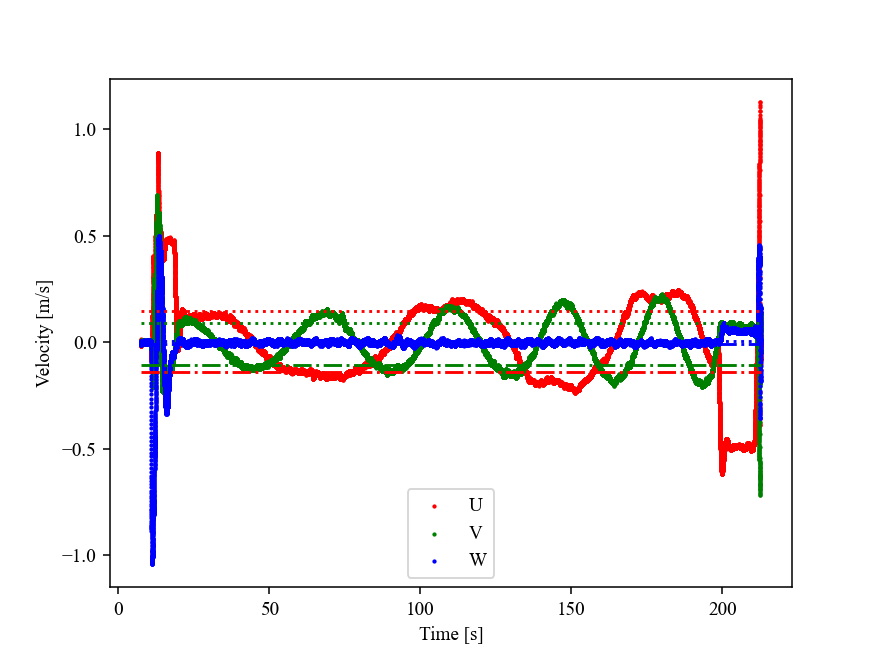

In [8]:
fig, ax = plt.subplots(1, 1)

ax.scatter(tvec, velocity[:, 0], color='r', s=1.5, label='U')
ax.scatter(tvec, velocity[:, 1], color='g', s=1.5, label='V')
ax.scatter(tvec, velocity[:, 2], color='b', s=1.5, label='W')
ax.plot(tvec[[0, -1]], Q1_vel[[0, 0]], color='r', linestyle='-.')
ax.plot(tvec[[0, -1]], Q3_vel[[0, 0]], color='r', linestyle=':')
ax.plot(tvec[[0, -1]], Q1_vel[[1, 1]], color='g', linestyle='-.')
ax.plot(tvec[[0, -1]], Q3_vel[[1, 1]], color='g', linestyle=':')
ax.plot(tvec[[0, -1]], Q1_vel[[2, 2]], color='b', linestyle='-.')
ax.plot(tvec[[0, -1]], Q3_vel[[2, 2]], color='b', linestyle=':')

ax.set_xlabel('Time [s]')
ax.set_ylabel('Velocity [m/s]')
ax.legend()

plt.show()

<IPython.core.display.Javascript object>


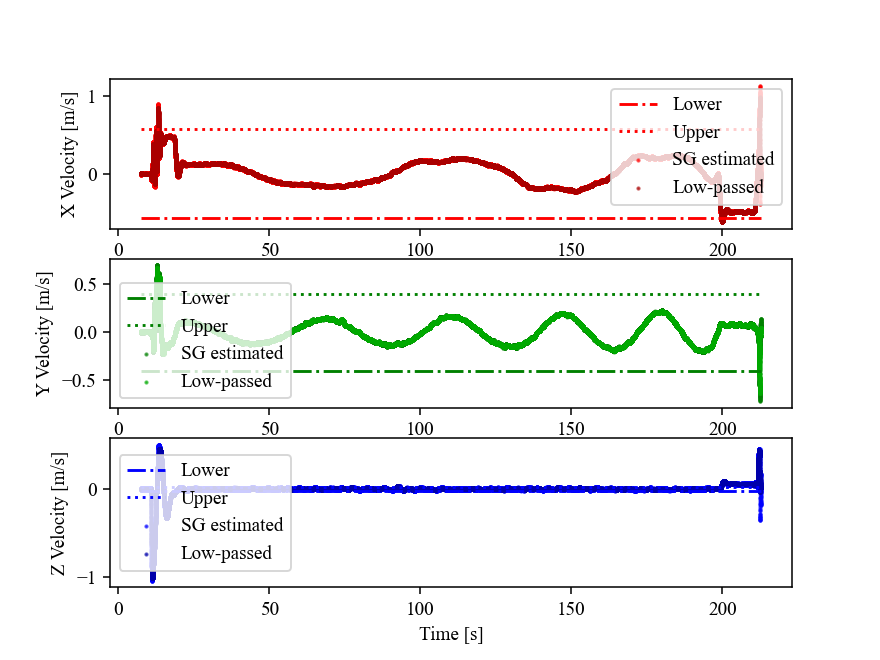

In [9]:
fig, ax = plt.subplots(3, 1)

for i, c, axis in zip(
    list(range(3)),
    ['r', 'g', 'b'],
    ['X', 'Y', 'Z']
):
    c_filter = 'aa'
    c_filter = c_filter + '00' if c == 'r' else '00' + c_filter
    c_filter = '00' + c_filter if c == 'b' else c_filter + '00'
    c_filter = '#' + c_filter
    IQR = Q3_vel[i] - Q1_vel[i]
    ax[i].scatter(tvec, velocity[:, i], color=c, s=1.5, label='SG estimated', alpha=0.6)
    ax[i].scatter(tvec, vel_smoothed[:, i], color=c_filter, s=1.5, label='Low-passed', alpha=0.6)
    ax[i].plot(tvec[[0, -1]], Q1_vel[[i, i]] - 1.5*IQR, color=c, linestyle='-.', label='Lower')
    ax[i].plot(tvec[[0, -1]], Q3_vel[[i, i]] + 1.5*IQR, color=c, linestyle=':', label='Upper')
    ax[i].set_ylabel(axis + ' Velocity [m/s]')
    ax[i].legend()
    
ax[-1].set_xlabel('Time [s]')

plt.show()

In [10]:
IQRz = Q3_vel[2] - Q1_vel[2]
vz_upper = Q3_vel[2] + 1.5*IQRz
vz_lower = Q3_vel[2] - 1.5*IQRz
nominal_flight_indicies = (vel_smoothed[:, 2] >= vz_lower) & (vel_smoothed[:, 2] <= vz_upper)

<IPython.core.display.Javascript object>


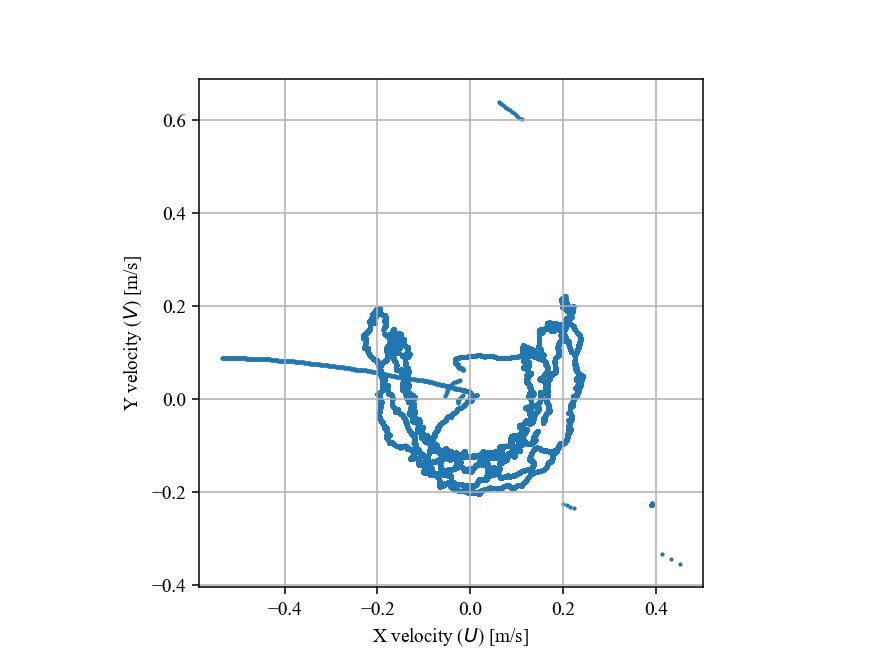

In [11]:
fig, ax = plt.subplots(1,1)

ax.scatter(vel_smoothed[nominal_flight_indicies, 0], vel_smoothed[nominal_flight_indicies, 1], s=1.5)
ax.grid()
ax.set_aspect('equal')
ax.set_xlabel('X velocity ($U$) [m/s]')
ax.set_ylabel('Y velocity ($V$) [m/s]')

plt.show()

### Kinematric Drag

Main force modeling is where the coefficient $k$ is emperically determined.

$$\vec{F}_D = k(\vec{\theta}) \cdot \vec{V}$$

The coefficient may depend on body orientation or the vehicles angles to the dominant wind.

<IPython.core.display.Javascript object>


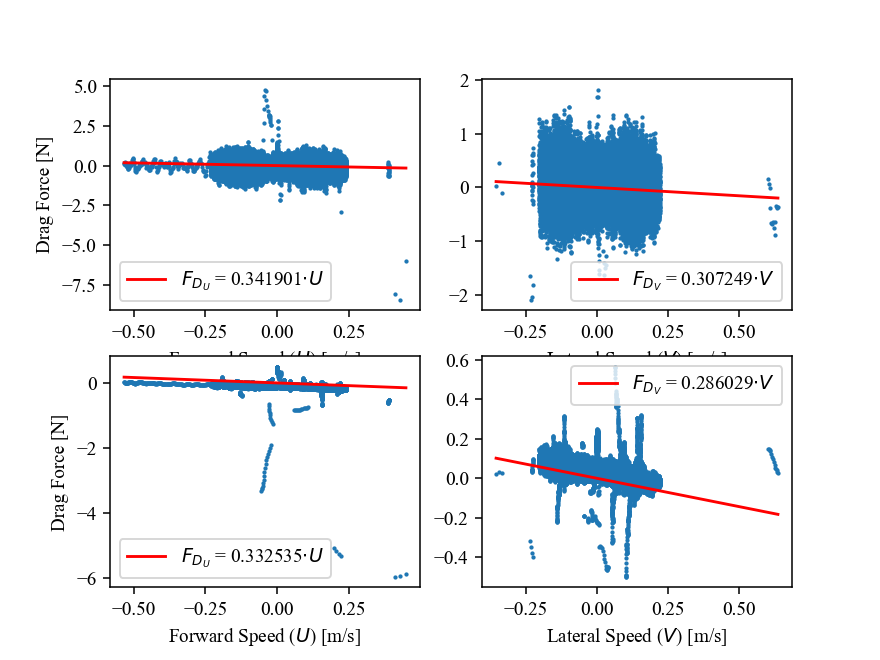

In [12]:
N_nf = np.sum(nominal_flight_indicies)
tnom = tvec[nominal_flight_indicies]
X = vel_smoothed[nominal_flight_indicies, :].reshape((N_nf, 3))
y = drag_force[nominal_flight_indicies, :].reshape((N_nf, 3))
y_smoothed = dsp.adaptive_low_pass(tnom, y, fc=1.)

Xplot = np.concatenate((X.min(axis=0).reshape((1,3)), X.max(axis=0).reshape((1,3))))

k_u = LinearRegression(fit_intercept=False).fit(X[:, 0].reshape((N_nf, 1)), y[:, 0].reshape((N_nf, 1)))
k_v = LinearRegression(fit_intercept=False).fit(X[:, 1].reshape((N_nf, 1)), y[:, 1].reshape((N_nf, 1)))
k_us = LinearRegression(fit_intercept=False).fit(X[:, 0].reshape((N_nf, 1)), y_smoothed[:, 0].reshape((N_nf, 1)))
k_vs = LinearRegression(fit_intercept=False).fit(X[:, 1].reshape((N_nf, 1)), y_smoothed[:, 1].reshape((N_nf, 1)))

fig, ax = plt.subplots(2, 2)

ax[0, 0].scatter(X[:, 0], y[:, 0], s=1.5)
ax[0, 0].plot(
    Xplot[:, 0], k_u.predict(Xplot[:, 0].reshape((2,1))),
    color='r', label=("$F_{D_U}$ = %f$\cdot U$" % (-1.*k_u.coef_))
)
ax[0, 0].legend()
ax[0, 1].scatter(X[:, 1], y[:, 1], s=1.5)
ax[0, 1].plot(
    Xplot[:, 1], k_v.predict(Xplot[:, 1].reshape((2,1))),
    color='r', label=("$F_{D_V}$ = %f$\cdot V$" % (-1.*k_v.coef_))
)
ax[0, 1].legend()

ax[0, 0].set_ylabel('Drag Force [N]')
ax[0, 0].set_xlabel('Forward Speed ($U$) [m/s]')
ax[0, 1].set_xlabel('Lateral Speed ($V$) [m/s]')

ax[1, 0].scatter(X[:, 0], y_smoothed[:, 0], s=1.5)
ax[1, 0].plot(
    Xplot[:, 0], k_us.predict(Xplot[:, 0].reshape((2,1))),
    color='r', label=("$F_{D_U}$ = %f$\cdot U$" % (-1.*k_us.coef_))
)
ax[1, 0].legend()
ax[1, 1].scatter(X[:, 1], y_smoothed[:, 1], s=1.5)
ax[1, 1].plot(
    Xplot[:, 1], k_vs.predict(Xplot[:, 1].reshape((2,1))),
    color='r', label=("$F_{D_V}$ = %f$\cdot V$" % (-1.*k_vs.coef_))
)
ax[1, 1].legend()

ax[1, 0].set_ylabel('Drag Force [N]')
ax[1, 0].set_xlabel('Forward Speed ($U$) [m/s]')
ax[1, 1].set_xlabel('Lateral Speed ($V$) [m/s]')


plt.show()

<IPython.core.display.Javascript object>


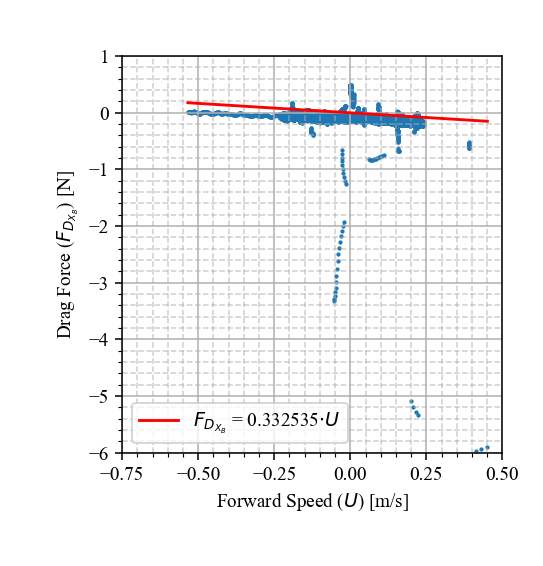

<IPython.core.display.Javascript object>


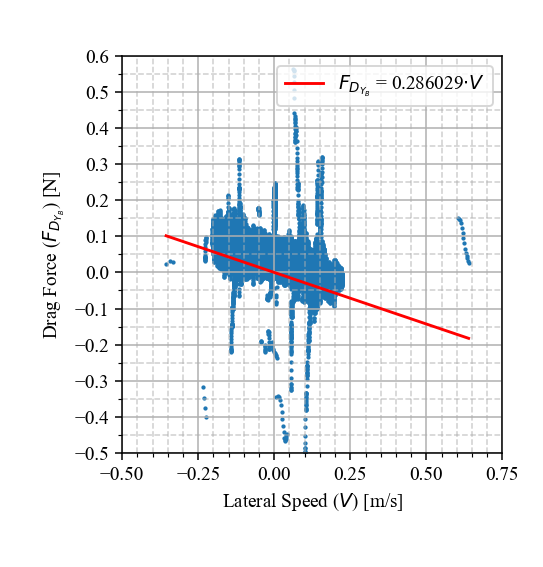

In [13]:
# Generating report figures
fig_fx, ax_fx = plt.subplots(1, 1)
fig_fy, ax_fy = plt.subplots(1, 1)

# Sizing
fig_fx.set_size_inches(2.875, 3)
fig_fy.set_size_inches(2.875, 3)

for axp in [ax_fx, ax_fy]:
    axp.set_position([0.225, 0.2, 0.7, 0.7])

# Axis labels
ax_fx.set_ylabel('Drag Force ($F_{D_{X_{B}}}$) [N]')
ax_fx.set_xlabel('Forward Speed ($U$) [m/s]')
ax_fy.set_ylabel('Drag Force ($F_{D_{Y_{B}}}$) [N]')
ax_fy.set_xlabel('Lateral Speed ($V$) [m/s]')

# Longitudinal drag
ax_fx.scatter(X[:, 0], y_smoothed[:, 0], s=1.5)
ax_fx.plot(
    Xplot[:, 0], k_us.predict(Xplot[:, 0].reshape((2,1))),
    color='r', label=("$F_{D_{X_{B}}}$ = %f$\cdot U$" % (-1.*k_us.coef_))
)
ax_fx.legend()

# Lateral Drag
ax_fy.scatter(X[:, 1], y_smoothed[:, 1], s=1.5)
ax_fy.plot(
    Xplot[:, 1], k_vs.predict(Xplot[:, 1].reshape((2,1))),
    color='r', label=("$F_{D_{Y_{B}}}$ = %f$\cdot V$" % (-1.*k_vs.coef_))
)
ax_fy.legend()

# Axis prettifying
ax_fx.set_xlim(left=-0.75, right=0.5)
ax_fx.set_ylim(bottom=-6, top=1)
ax_fx.xaxis.set_major_locator(ticker.MultipleLocator(0.25))
ax_fx.xaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax_fx.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax_fx.yaxis.set_minor_locator(ticker.MultipleLocator(0.2))

ax_fy.set_xlim(left=-0.5, right=0.75)
ax_fy.set_ylim(bottom=-.5, top=0.6)
ax_fy.xaxis.set_major_locator(ticker.MultipleLocator(0.25))
ax_fy.xaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax_fy.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax_fy.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))

for axp in [ax_fx, ax_fy]:
    axp.grid(True, which='major', linestyle='-')
    axp.grid(True, which='minor', linestyle='--', alpha=0.6)

fig_fx.savefig("../report/project-report/figures/pow/drag-fx-linear.png")
fig_fy.savefig("../report/project-report/figures/pow/drag-fy-linear.png")
    
plt.show()

<IPython.core.display.Javascript object>


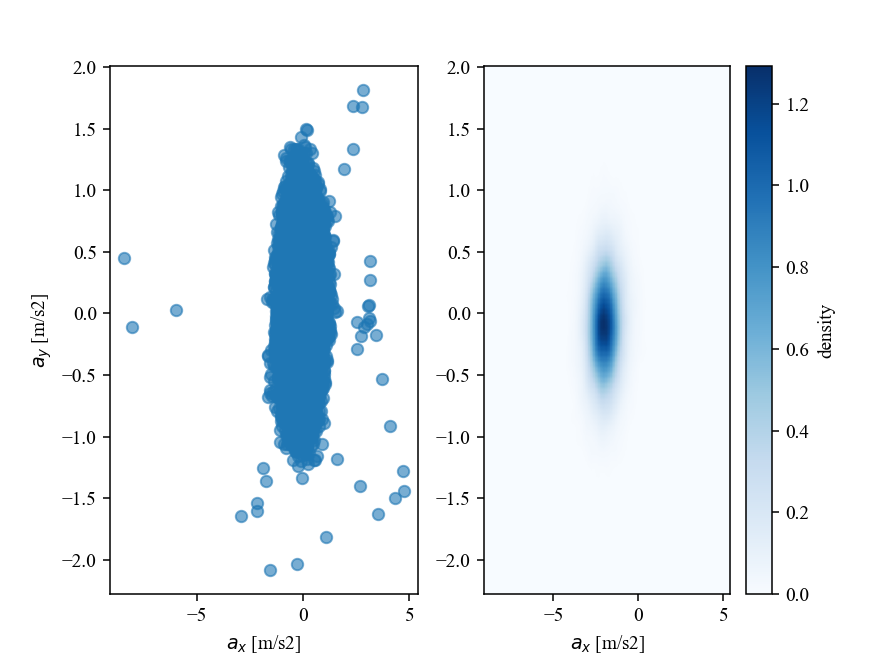

In [14]:
from scipy.stats import gaussian_kde

kde = gaussian_kde(y[:, :2].T)

xgrid = np.linspace(-4, 4, 100)
ygrid = np.linspace(-2, 2, 100)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))

fig = plt.figure()
# ax = fig.add_axes([.1, .1, 0.8, 0.8], projection='3d')
axl = fig.add_axes([.125, .1, 0.35, 0.8])
axl.scatter(y[:, 0], y[:, 1], alpha=0.6)
axr = fig.add_axes([.55, .1, 0.35, 0.8])
im = axr.imshow(
    Z.reshape(Xgrid.shape),
    origin='lower', aspect='auto',
    extent=list(axl.get_xlim() + axl.get_ylim()),
    cmap='Blues'
)


cb = plt.colorbar(im)
cb.set_label("density")

axl.set_ylabel('$a_y$ [m/s2]')
axl.set_xlabel('$a_x$ [m/s2]')
axr.set_xlabel('$a_x$ [m/s2]')

plt.show()

0.05795025531617653 0.049845706152171286


<IPython.core.display.Javascript object>


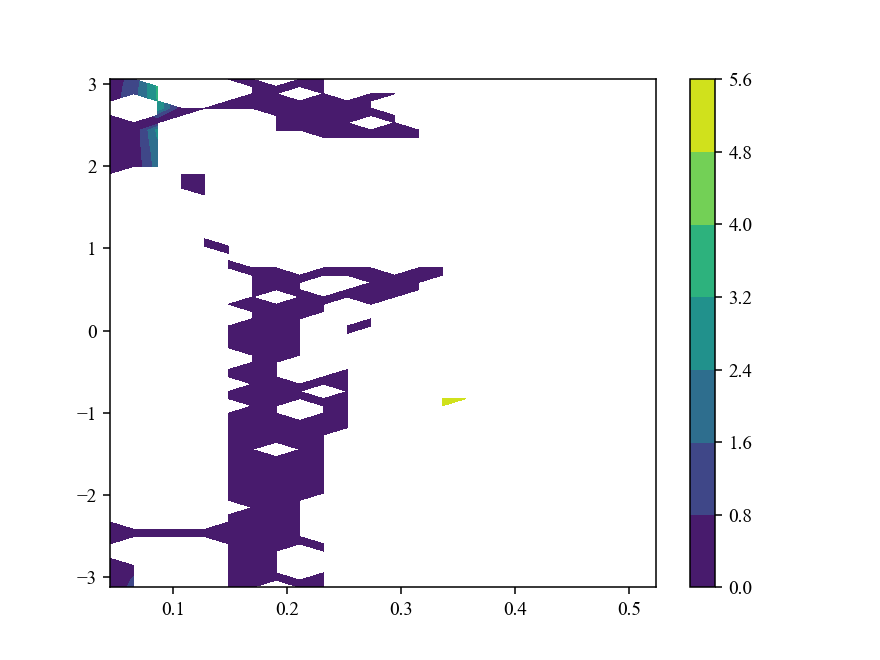

In [15]:
r_vel = np.sqrt(X[:, 0]**2 + X[:, 1]**2)
theta_vel = np.arctan2(X[:, 1], X[:, 0])
F_mag = np.sqrt(np.sum(y_smoothed[:,:2]**2, axis=1))

rvel_mean = np.mean(r_vel)
a = -(k_us.coef_ * rvel_mean)[0,0]
b = -(k_vs.coef_ * rvel_mean)[0,0]

print(a,b)

theta_bins = np.linspace(-np.pi, np.pi, 72)      # 0 to 360 in steps of 360/N.
r_bins = np.linspace(0., .5, 25) 
dtheta = theta_bins[1] - theta_bins[0]
dr = r_bins[1] - r_bins[0]
"""
H, xedges, yedges = np.histogram2d(
    r_vel, theta_vel,
    bins=(len(r_bins) - 1, len(theta_bins) - 1),
    weights=F_mag
)
"""

# @numba.jit(nopython=True)
def average_2d_bins(x, y, z, xbins, ybins):
    averages = np.zeros((xbins.shape[0] - 1, ybins.shape[0] - 1), dtype=np.float64)
    for i in numba.prange(averages.shape[0]):
        for j in numba.prange(averages.shape[1]):
            index = (xbins[i] <= x) & (x < xbins[i+1]) & (ybins[j] <= y) & (y < ybins[j+1])
            z_ij = z[index]
            if len(z_ij) > 0:
                averages[i, j] = np.mean(z_ij)
            else:
                averages[i, j] = np.nan
    return averages

fmag_avg = average_2d_bins(r_vel, theta_vel, F_mag, r_bins, theta_bins)
theta_grid, r_grid = np.meshgrid(r_bins, theta_bins)


fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
ax = fig.add_subplot(1, 1, 1)

cf = ax.contourf(theta_grid[:-1, :-1] + dtheta/2, r_grid[:-1, :-1] + dr/2, fmag_avg.T)
fig.colorbar(cf, ax=ax)
# ax.set_xlim((0., 0.5))
# ax.set_ylim((0., 0.5))
# ax.set_zlim((8., 9.5))

plt.show()

[[0.04517965]] [0.11377905]


<IPython.core.display.Javascript object>


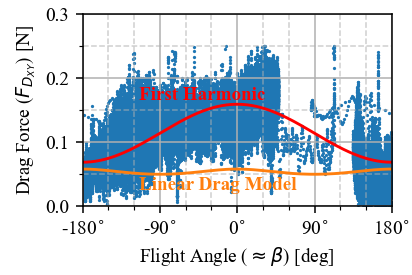

In [16]:
ind = F_mag <= 0.25
# np.full(shape=F_mag.shape, fill_value=1, dtype=np.bool)# (8.8 <= F_mag) & (F_mag <= 9.2)

freq = 1.

y = F_mag[ind]
N = y.shape[0]
y = y.reshape((N, 1))
X = theta_vel[ind]
X = np.cos(X.reshape((N, 1)))
"""
X = np.concatenate(
    (np.cos(freq*X).reshape((N, 1)), np.sin(freq*X).reshape((N, 1))),
    axis=1
)
"""
theta_ls = np.linspace(-np.pi, np.pi, 360)
theta_ls = theta_ls.reshape((theta_ls.shape[0], 1))

cyclical_drag = LinearRegression(fit_intercept=True).fit(X, y)
print(cyclical_drag.coef_, cyclical_drag.intercept_)
if len(cyclical_drag.coef_[0]) > 1:
    phase_angle = np.arctan2(cyclical_drag.coef_[0, 0], cyclical_drag.coef_[0, 1])
    print("Phase angle: %f [deg]" % (phase_angle*180./np.pi))

"""
yp = cyclical_drag.predict(np.concatenate(
    (np.cos(freq*theta_ls), np.sin(freq*theta_ls)),
    axis=1
))
"""

yp = cyclical_drag.predict(np.cos(freq*theta_ls))

ylm = a*b/np.sqrt((b*np.cos(theta_ls))**2 + (a*np.sin(theta_ls))**2)
# print(ylm)

fig, ax = plt.subplots(1,1)
fig.set_size_inches(3, 2)
ax.set_position([0.2, 0.25, 0.75, 0.7])

ax.scatter(theta_vel[ind], F_mag[ind], s=0.5)
ax.plot(theta_ls, yp, color='r', label='First Drag Harmonic', zorder=2)
#ax.plot(theta_ls[:,0], yp[:,0], color='r', linewidth=3., label='First Harmonic')
ax.plot(theta_ls, ylm[:,0], color='C1', label='Linear Drag Model', zorder=2)

ax.set_ylabel('Drag Force ($F_{D_{X Y}}$) [N]')
ax.set_xlabel('Flight Angle ($\\approx \\beta$) [deg]')

def deg_fmt(x, pos):
    return "%.0f$^{\circ}$" % (x*180./np.pi)

ax.set_xlim(left=-np.pi, right=np.pi)
ax.set_ylim(bottom=0, top=0.3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5*np.pi))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(np.pi/6.))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))

ax.xaxis.set_major_formatter(deg_fmt)

ax.text(
    -2, 0.165,
    "First Harmonic",
    color='r',
    fontweight='heavy'
)
ax.text(
    -2, 0.025,
    "Linear Drag Model",
    color='C1',
    fontweight='heavy'
)

ax.grid(True, which='major')
ax.grid(True, which='minor', linestyle='--', alpha=0.6)

fig.savefig("../report/project-report/figures/pow/drag-first-harmonic.png")

plt.show()

[[-0.01107915  0.01064127]]


<IPython.core.display.Javascript object>


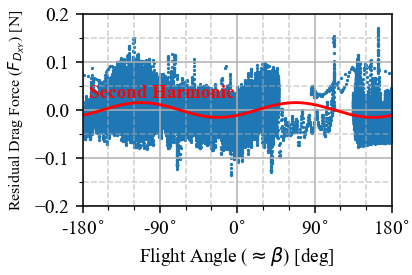

In [17]:
c1_coeff = cyclical_drag.coef_[0][0]
y_for = y - c1_coeff*np.cos(theta_vel[ind]).reshape((N, 1)) - cyclical_drag.intercept_[0]

freq = 2.

X = np.stack([
    np.cos(freq*theta_vel[ind]), np.sin(freq*theta_vel[ind])
]).T

# X = np.sin(freq*theta_vel[ind]).reshape((N, 1))

cyclical_drag2 = LinearRegression(fit_intercept=False).fit(X, y_for)

Xp = np.concatenate((
    np.cos(freq*theta_ls), np.sin(freq*theta_ls)
), axis=1)

# Xp = np.sin(freq*theta_ls)

print(cyclical_drag2.coef_)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3, 2)
ax.set_position([0.2, 0.25, 0.75, 0.7])

ax.scatter(theta_vel[ind], y_for, s=0.5)
ax.plot(theta_ls, cyclical_drag2.predict(Xp), color='r')

ax.set_ylabel('Residual Drag Force ($F_{D_{XY}}$) [N]', fontsize='small')
ax.set_xlabel('Flight Angle ($\\approx \\beta$) [deg]')

ax.set_xlim(left=-np.pi, right=np.pi)
ax.set_ylim(bottom=-0.2, top=0.2)

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5*np.pi))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(np.pi/6.))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))

ax.xaxis.set_major_formatter(deg_fmt)

ax.text(
    -3, 0.025,
    "Second Harmonic",
    color='r',
    fontweight='heavy'
)

ax.grid(True, which='major')
ax.grid(True, which='minor', linestyle='--', alpha=0.6)

fig.savefig("../report/project-report/figures/pow/drag-second-harmonic.png")

plt.show()

<IPython.core.display.Javascript object>


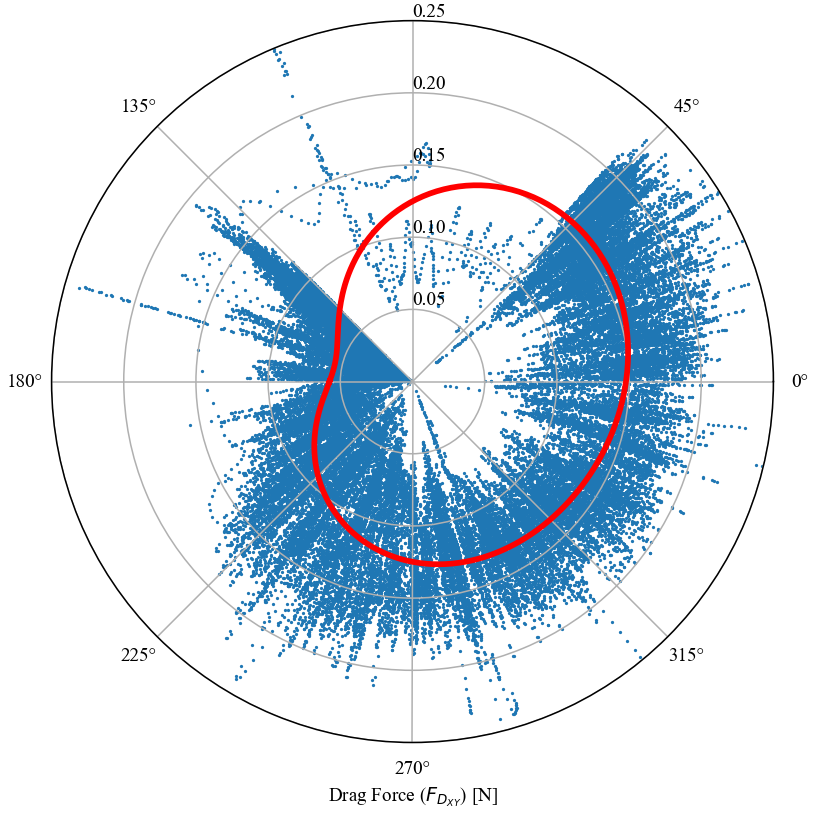

In [18]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "polar"})

fig.set_size_inches(6,6)
ax.set_position([0.05, 0.1, 0.9, 0.875])

ax.scatter(theta_vel[ind], F_mag[ind], s=0.5)
ax.plot(
    theta_ls,
     cyclical_drag.predict(np.cos(1*theta_ls)) + cyclical_drag2.predict(Xp),
    color='r',
    linewidth=3.
)

ax.set_rlabel_position(90)
ax.set_rlim(0, 0.25)
ax.set_xlabel("Drag Force ($F_{D_{XY}}$) [N]")

fig.savefig("../report/project-report/figures/pow/drag-polar.png")

plt.show()

<IPython.core.display.Javascript object>


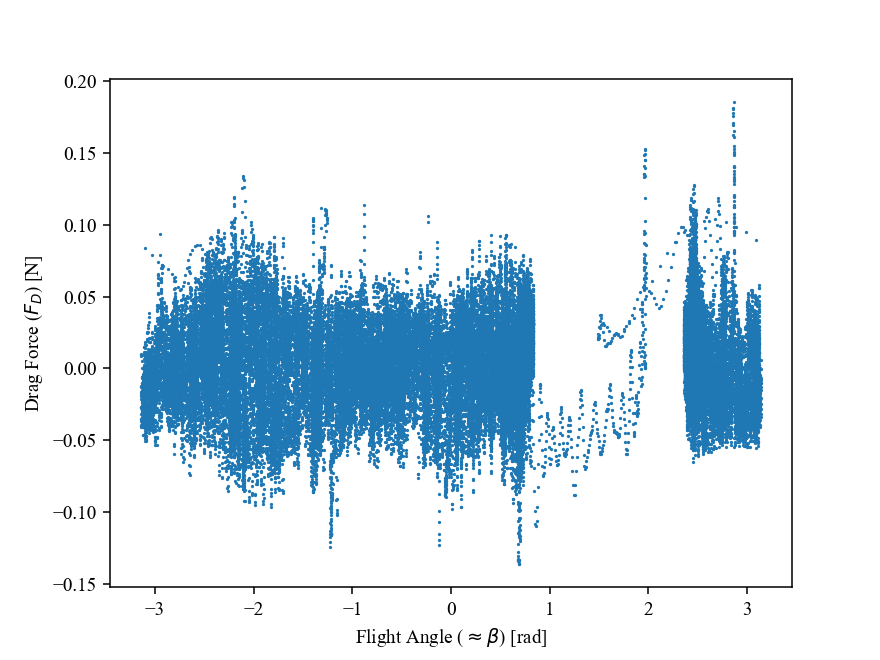

In [19]:
c2_coef = cyclical_drag2.coef_[0][0]
s2_coef = cyclical_drag2.coef_[0][1]
y_sor = y_for - c2_coef*np.cos(2*theta_vel[ind]).reshape((N, 1)) - s2_coef*np.sin(2*theta_vel[ind]).reshape((N, 1))

fig, ax = plt.subplots(1, 1)

ax.scatter(theta_vel[ind], y_sor, s=0.5)

ax.set_ylabel('Drag Force ($F_D$) [N]')
ax.set_xlabel('Flight Angle ($\\approx \\beta$) [rad]')

plt.show()

[[0.61948911]] 0.0


<IPython.core.display.Javascript object>


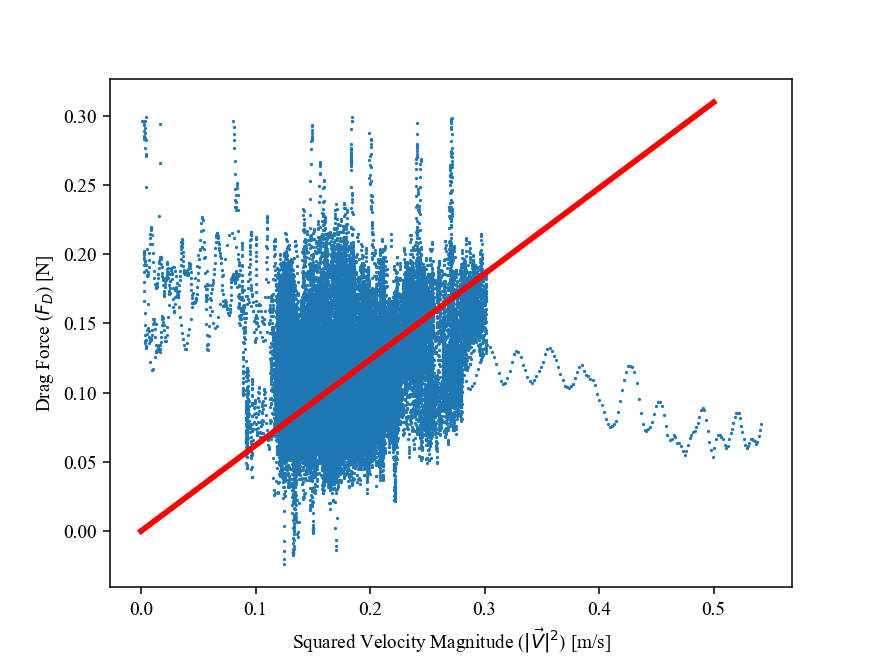

In [20]:
def F_mag_angle_comp(theta):
    c1 = cyclical_drag.coef_[0, 0]
    c2 = cyclical_drag2.coef_[0, 0]
    s2 = cyclical_drag2.coef_[0, 0]
    return c1*np.cos(theta) + c2*np.cos(2*theta) + s2*np.sin(2*theta)

F_mag_radial = F_mag - F_mag_angle_comp(theta_vel)

ind = F_mag_radial <= 0.3
# np.full(shape=r_vel.shape, fill_value=1, dtype=np.bool)

X = r_vel[ind]
y = F_mag_radial[ind]
X = X.reshape((X.shape[0], 1))
# X = X ** 2
# X = np.concatenate((X, X**2), axis=1)
y = y.reshape((y.shape[0], 1))

radial_drag = LinearRegression(fit_intercept=False).fit(X, y)
print(radial_drag.coef_, radial_drag.intercept_)

r_ls = np.linspace(0, 0.5, 100).reshape((100, 1))

fig, ax = plt.subplots(1, 1)

ax.scatter(r_vel[ind], F_mag_radial[ind], s=0.5)

ax.plot(r_ls, radial_drag.predict(
    r_ls
    # np.concatenate((r_ls, r_ls**2), axis=1)
), color='r', linewidth=3.)

ax.set_xlabel('Squared Velocity Magnitude ($|\\vec{V}|^2$) [m/s]')
ax.set_ylabel('Drag Force ($F_D$) [N]')

plt.show()

<IPython.core.display.Javascript object>


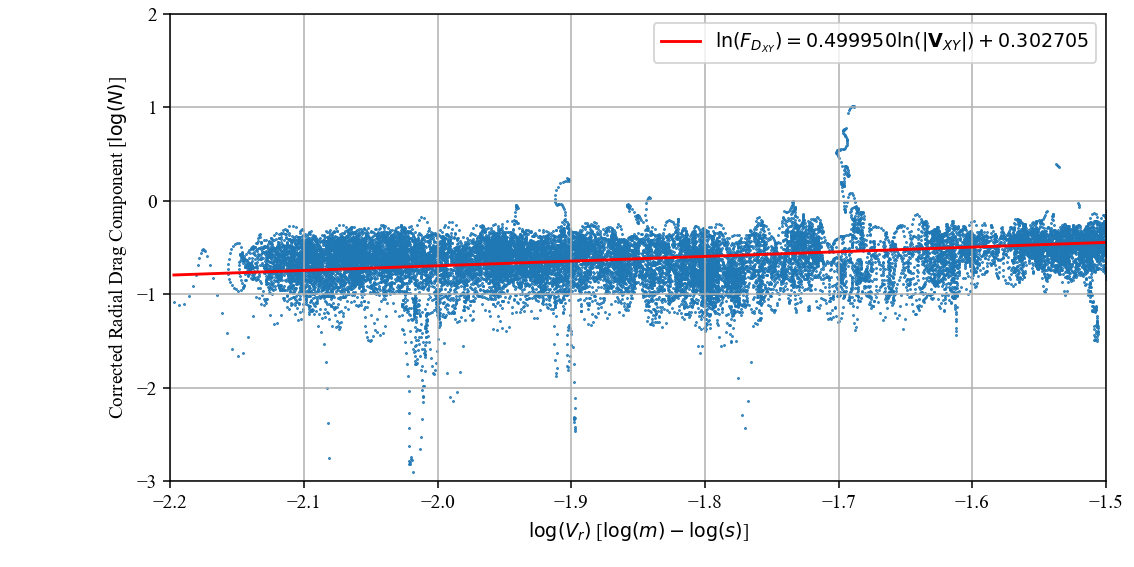

[[0.49994986]] [0.30270539]


In [21]:
F_mag_angle_component =  F_mag_angle_comp(theta_vel)

ind = (
    (F_mag_angle_component > 0.01) &
    (np.log(r_vel) > -2.2) &
    (np.log(r_vel) < -1.) &
    (F_mag > 0.01)
)

mean_F_mag_angle = 0.2224

y = np.log(F_mag[ind]) - np.log(mean_F_mag_angle + F_mag_angle_component[ind])
X = np.log(r_vel[ind])

y = y.reshape((y.shape[0], 1))
X = X.reshape((X.shape[0], 1))

log_radial_drag = LinearRegression().fit(X, y)

fig, ax  = plt.subplots(1, 1)

fig.set_size_inches(6,3)
ax.set_position([.15, .15, 0.825, 0.825])

ax.scatter(
    np.log(r_vel[ind]),
    np.log(F_mag[ind]) - np.log(mean_F_mag_angle + F_mag_angle_component[ind]),
    s=0.25
)

Xp = np.array([[X.min()], [X.max()]])

ax.plot(
    Xp,
    log_radial_drag.predict(Xp),
    c='r',
    label=("$\ln(F_{D_{XY}}) = %f\ln(|\mathbf{V}_{XY}|) + %f$" % (log_radial_drag.coef_, log_radial_drag.intercept_))
)

ax.set_xlabel("$\log(V_r)$ [$\log (m) - \log(s)$]")
ax.set_ylabel("Corrected Radial Drag Component [$\log(N)$]")

ax.set_xlim(left=-2.2, right=-1.5)
ax.set_ylim(bottom=-3, top=2)

ax.legend()

ax.grid(True)

plt.show()

fig.savefig("../report/project-report/figures/pow/drag-ln-speed.png")

print(log_radial_drag.coef_, log_radial_drag.intercept_)

## Angle of Attack

Estimating angle of attack to use with the drag models. Most aircraft just use $\arctan(W/U)$ assuming $\beta$ is small but this is not the case with quadcopters.

<IPython.core.display.Javascript object>


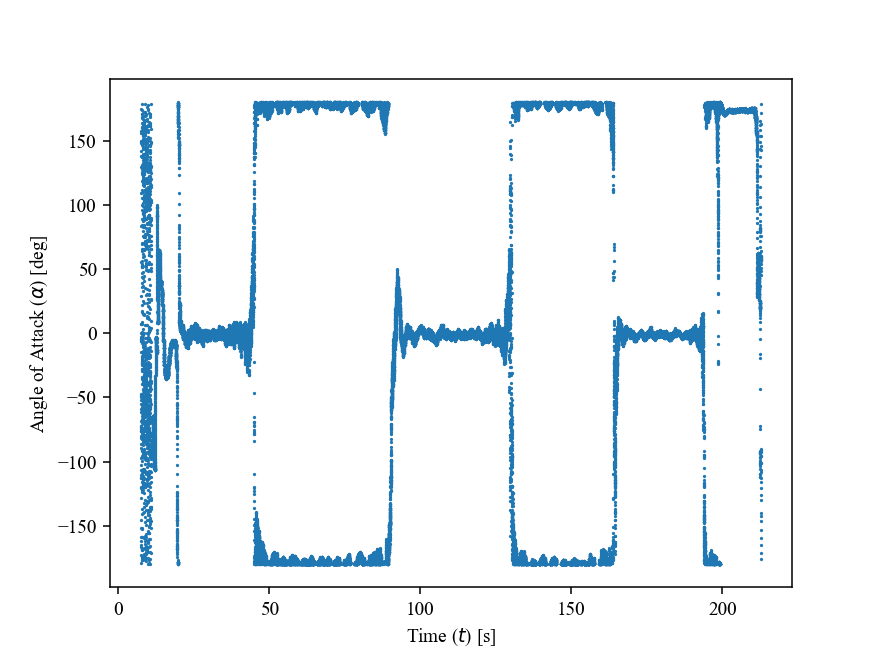

In [22]:
alpha = np.arctan2(velocity[:, 2], velocity[:, 0])

fig, ax = plt.subplots(1, 1)

ax.scatter(tvec, 180./np.pi*alpha, s=0.5)

ax.set_xlabel('Time ($t$) [s]')
ax.set_ylabel('Angle of Attack ($\\alpha$) [deg]')

plt.show()

<IPython.core.display.Javascript object>


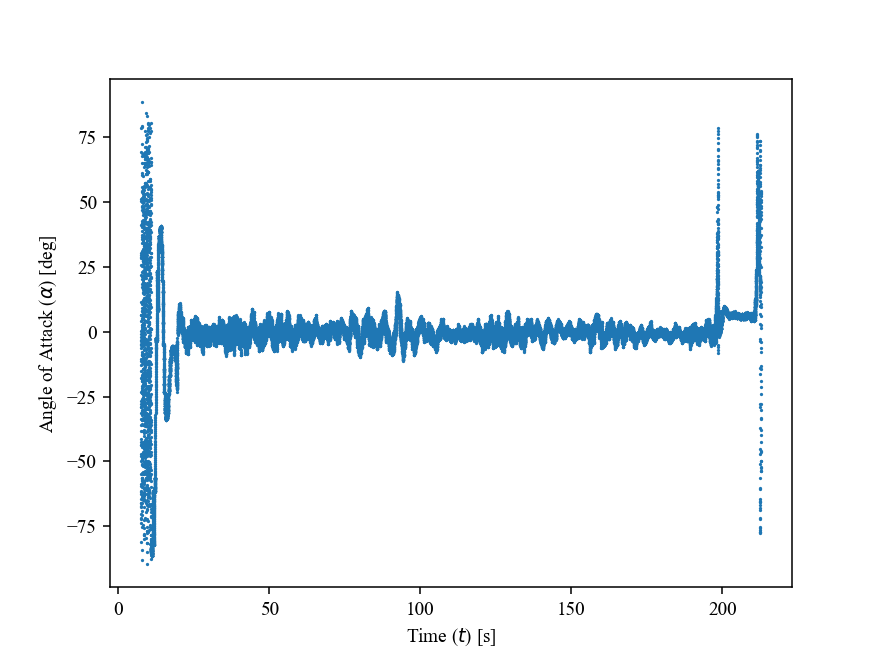

In [23]:
alpha = np.arctan2(velocity[:, 2], np.sqrt(velocity[:, 0]**2 + velocity[:, 1]**2))

fig, ax = plt.subplots(1, 1)

ax.scatter(tvec, 180./np.pi*alpha, s=0.5)

ax.set_xlabel('Time ($t$) [s]')
ax.set_ylabel('Angle of Attack ($\\alpha$) [deg]')

plt.show()

<IPython.core.display.Javascript object>


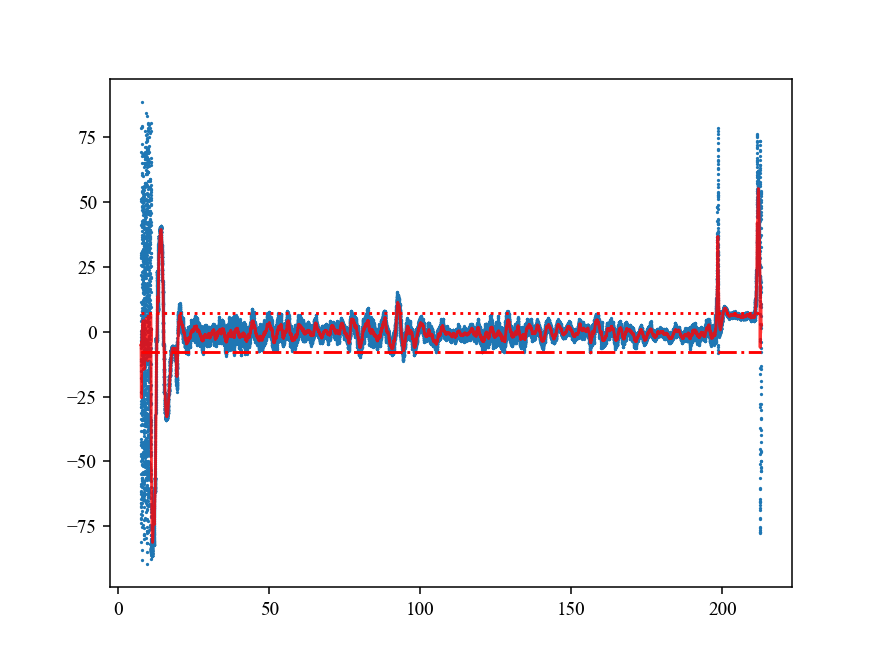

In [24]:
# alpha = vel_smoothed[:, :]
alpha = velocity[:, :]
alpha = np.arctan2(alpha[:, 2], np.sqrt(alpha[:, 0]**2 + alpha[:, 1]**2))

Q2 = np.median(alpha)
Q1 = np.median(alpha[alpha < Q2])
Q3 = np.median(alpha[alpha > Q2])
IQR = Q3 - Q1

alpha_lp = dsp.adaptive_low_pass(tvec, alpha, fc=1.)

rtd = 180./np.pi

fig, ax = plt.subplots(1, 1)

ax.scatter(tvec, alpha*rtd, s=0.5)
ax.plot(tvec, alpha_lp*rtd, color='r', alpha=0.8)
ax.plot(tvec[[0, -1]], np.ones(2)*(Q3 + 1.5*IQR)*rtd, color='r', linestyle=':')
ax.plot(tvec[[0, -1]], np.ones(2)*(Q1 - 1.5*IQR)*rtd, color='r', linestyle='-.')

plt.show()

nom_alpha_ind = (alpha < Q3 + 1.5*IQR) & (alpha > Q1 - 1.5*IQR)

tnom_a = tvec[nom_alpha_ind]
alpha = alpha[nom_alpha_ind]


<IPython.core.display.Javascript object>


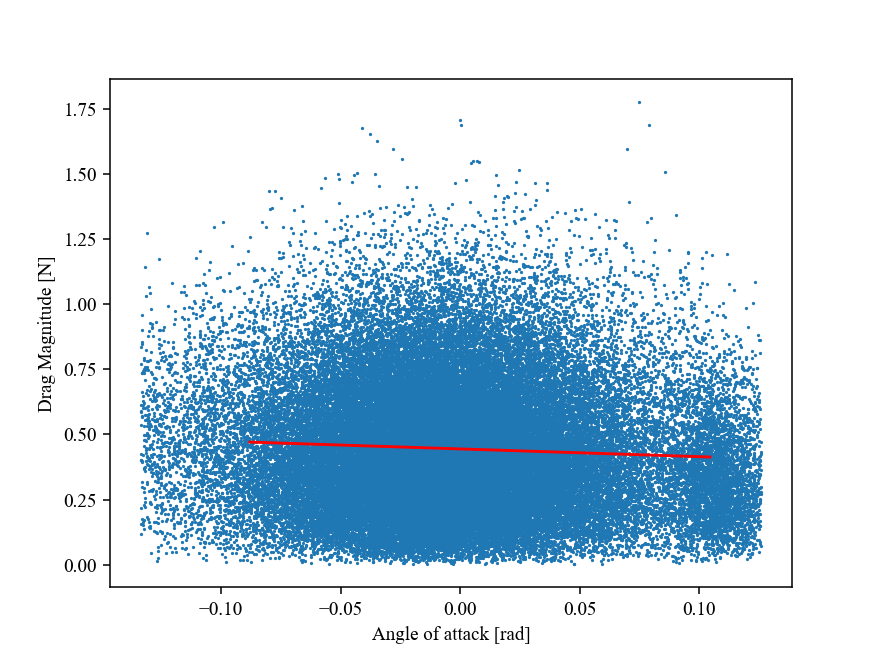

[[-0.29761426]] [0.44445727]


In [25]:
F_mag_alpha = np.sum(drag_force[nom_alpha_ind, :2]**2, axis=1)**0.5

ind = F_mag_alpha < 2.0

X = alpha[ind]
N = X.shape[0]

drag_alpha = LinearRegression().fit(
    X.reshape((N, 1)), F_mag_alpha[ind].reshape((N, 1))
)

fig, ax = plt.subplots(1, 1)

ax.scatter(alpha[ind], F_mag_alpha[ind], s=0.5)
ax.plot(
    np.array([[alpha[0]], [alpha[-1]]]),
    drag_alpha.predict(np.array([[alpha[0]], [alpha[-1]]])),
    color='r'
)

ax.set_xlabel('Angle of attack [rad]')
ax.set_ylabel('Drag Magnitude [N]')

plt.show()

print(drag_alpha.coef_, drag_alpha.intercept_)